In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Multiply, Dense, Concatenate, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


In [2]:
file_path = '../dataset/HotelRec_with_sentiment_scores.csv'

In [3]:
data = pd.read_csv(file_path)

In [4]:
data.shape

(12996750, 7)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12996750 entries, 0 to 12996749
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   hotel_url      object 
 1   author         object 
 2   date           object 
 3   rating         float64
 4   title          object 
 5   text           float64
 6   property_dict  object 
dtypes: float64(2), object(5)
memory usage: 694.1+ MB


In [6]:
data.rename(columns={'text': 'senti_score'}, inplace=True)

In [7]:
data.head()

,hotel_url,author,date,rating,title,senti_score,property_dict
0,Hotel_Review-g194775-d1121769-Reviews-Hotel_Ba...,ashleyn763,2014-10-01T00:00:00,5.0,Excellent in every way!,0.300000,"{'service': 5.0, 'location': 5.0, 'value': 5.0}"
1,Hotel_Review-g303503-d1735469-Reviews-Pousada_...,TwoMonkeysTravel,2017-03-01T00:00:00,5.0,Natural Luxury,0.267755,"{'service': 5.0, 'sleep quality': 5.0, 'value'..."
2,Hotel_Review-g303503-d1735469-Reviews-Pousada_...,heckfy,2016-01-01T00:00:00,5.0,"Loved out stay, a lot of character",0.284058,"{'rooms': 5.0, 'service': 5.0, 'cleanliness': ..."
3,Hotel_Review-g303503-d1735469-Reviews-Pousada_...,TwoMonkeysTravel,2015-07-01T00:00:00,5.0,"Really nice staff, yummy breakfast and the mon...",0.227083,"{'rooms': 5.0, 'service': 5.0, 'value': 5.0}"
4,Hotel_Review-g644280-d1821178-Reviews-Agrituri...,Kelleygirl2,2017-05-01T00:00:00,4.0,Gorgeous agriturismo with beautiful grounds an...,0.261111,{'location': 4.0}


In [8]:
data['senti_score'].describe()

count    1.299675e+07
mean     2.598039e-01
std      1.655226e-01
min     -1.000000e+00
25%      1.614419e-01
50%      2.599421e-01
75%      3.618519e-01
max      1.000000e+00
Name: senti_score, dtype: float64

## Data Preprocessing

In [9]:
# deleting unnnecessary columns
data = data.drop(['title'], axis=1)

# remove duplicates
data.drop_duplicates(inplace=True)


## handle author column
# handling missing values, only this column has NaN
data.dropna(subset=['author'], inplace=True) 

# remove the "/undefined" in the 'author'
data = data[data['author'] != '/undefined']


## handle date column
# convert the date column to datetime format
data['date'] = pd.to_datetime(data['date'])

# overwrite the 'date' column with year only
data['date'] = data['date'].dt.year
data.rename(columns={'date': 'year'}, inplace=True)
data['rating'] = data['rating'].astype(np.int64)

### outlier detection

In [10]:
year_frequency_sorted = data['year'].value_counts().sort_index()
print(year_frequency_sorted)

year
2002        170
2003       2742
2004      11288
2005      28566
2006      55446
2007      97264
2008     134703
2009     196845
2010     298062
2011     572241
2012     990357
2013    1270835
2014    1463219
2015    1722289
2016    1793419
2017    1564191
2018    1267967
2019     310202
Name: count, dtype: int64


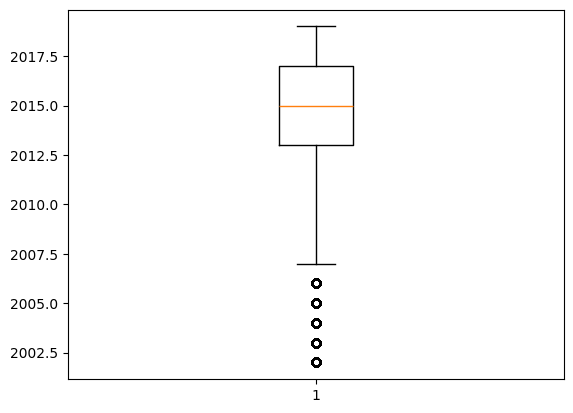

In [11]:
plt.boxplot(data['year'])
plt.show()

In [12]:
data = data[~data['year'].isin([2002, 2003, 2004, 2005, 2006])]

### Extract Hotel Name

In [13]:
def extract_hotel_name(url):
    # Split the string by "Reviews-" and take the second part
    try:
        hotel_part = url.split("Reviews-")[1]
        # Split by the first dash to isolate the hotel name part
        hotel_name = hotel_part.split("-")[0]
        # Replace underscores with spaces for better readability
        return hotel_name.replace("_", " ")
    except IndexError:
        return None
# create a new column with the hotel name
data['hotel_name'] = data['hotel_url'].apply(extract_hotel_name)

### Encode Categorical Features

In [14]:
label_encoder_author = LabelEncoder()
label_encoder_hotel = LabelEncoder()
data['author_id'] = label_encoder_author.fit_transform(data['author'])
data['hotel_id'] = label_encoder_hotel.fit_transform(data['hotel_name'])

In [15]:
# count the number of hotels
data['hotel_id'].nunique()

325689

In [11]:
# # split out the different rating categories form "property_dict"
# data['property_dict'] = data['property_dict'].apply(ast.literal_eval)
# # extract the special ratings into individual columns
# ratings_data = data['property_dict'].apply(pd.Series)

# # join the extracted ratings to a new DataFrame which may use in NCF
# data = data.join(ratings_data)

## Clustering Analysis

In [16]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [17]:
clustering_features = ['senti_score', 'rating', 'year']
X = data[clustering_features]

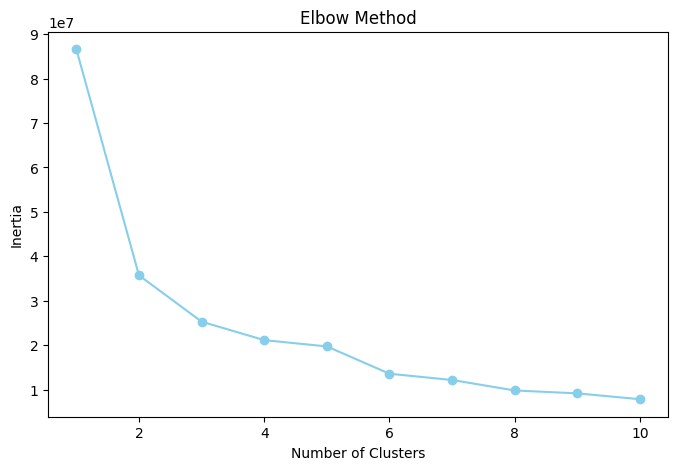

In [18]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o',color='skyblue')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [19]:
# Apply k-means clustering with optimal clusters
optimal_clusters = 3 # Set based on elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(X)
print("Clustering completed.")

Clustering completed.


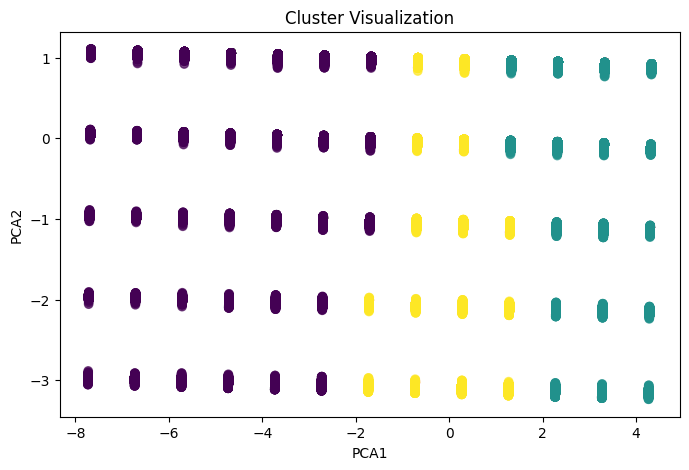

In [20]:
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['cluster'], cmap='viridis', marker='o', alpha=0.7)
plt.title('Cluster Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [21]:
data.head()

,hotel_url,author,year,rating,senti_score,property_dict,hotel_name,author_id,hotel_id,cluster
0,Hotel_Review-g194775-d1121769-Reviews-Hotel_Ba...,ashleyn763,2014,5,0.300000,"{'service': 5.0, 'location': 5.0, 'value': 5.0}",Hotel Baltic,369752,129241,2
1,Hotel_Review-g303503-d1735469-Reviews-Pousada_...,TwoMonkeysTravel,2017,5,0.267755,"{'service': 5.0, 'sleep quality': 5.0, 'value'...",Pousada Rumo dos Ventos,336642,238867,1
2,Hotel_Review-g303503-d1735469-Reviews-Pousada_...,heckfy,2016,5,0.284058,"{'rooms': 5.0, 'service': 5.0, 'cleanliness': ...",Pousada Rumo dos Ventos,438884,238867,1
3,Hotel_Review-g303503-d1735469-Reviews-Pousada_...,TwoMonkeysTravel,2015,5,0.227083,"{'rooms': 5.0, 'service': 5.0, 'value': 5.0}",Pousada Rumo dos Ventos,336642,238867,2
4,Hotel_Review-g644280-d1821178-Reviews-Agrituri...,Kelleygirl2,2017,4,0.261111,{'location': 4.0},Agriturismi Il Castello La Grancia,194495,5613,1


In [22]:
data.to_csv('../dataset/HotelRec.csv', index=False, encoding='utf-8')

## Recommendation Models

### SVD Algorithm

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import SVD, KNNBasic, KNNWithZScore
from surprise import SVD, Dataset, Reader, accuracy

In [24]:
!pip install scikit-surprise

In [25]:
path = "../dataset/HotelRec.csv"
data = pd.read_csv(path)

In [ ]:
def svd_for_each_cluster(data):

    all_predictions = [] 
    
    unique_clusters = data['cluster'].unique()
    
    for cluster in unique_clusters:
        print(f"Processing cluster: {cluster}")
        
        cluster_data = data[data['cluster'] == cluster]
        reader = Reader(rating_scale=(1, 5))
        dataset = Dataset.load_from_df(cluster_data[['author_id', 'hotel_id', 'rating']], reader)
        trainset, testset = train_test_split(dataset, test_size=0.2, random_state=42)
        
        algo = SVD(n_factors=100, lr_all=0.05, reg_all=0.1, biased=True)
        algo.fit(trainset)
        
        # Predict on the test set
        predictions = algo.test(testset)
        all_predictions.extend(predictions)
        
        # Evaluate RMSE and MAE for the current cluster
        print(f"Cluster {cluster} RMSE:")
        accuracy.rmse(predictions, verbose=True)
        print(f"Cluster {cluster} MAE:")
        accuracy.mae(predictions, verbose=True)
        
        # Calculate accuracy
        cluster_accuracy = calculate_accuracy(predictions, threshold=0.5)
        print(f"Cluster {cluster} Accuracy: {cluster_accuracy:.2f}%")
    
    print("\n")
    print("Calculating overall metrics...")
    overall_rmse = accuracy.rmse(all_predictions, verbose=True)
    overall_mae = accuracy.mae(all_predictions, verbose=True)
    overall_accuracy = calculate_accuracy(all_predictions, threshold=0.5)
    
    print(f"Overall RMSE: {overall_rmse}")
    print(f"Overall MAE: {overall_mae}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")

def calculate_accuracy(predictions, threshold=0.5):
    correct_predictions = 0
    for pred in predictions:
        if abs(pred.r_ui - pred.est) <= threshold:
            correct_predictions += 1
    accuracy_percentage = (correct_predictions / len(predictions)) * 100
    return accuracy_percentage

In [28]:
svd_for_each_cluster(data)

Processing cluster: 2
Cluster 2 RMSE:
RMSE: 0.9392
Cluster 2 MAE:
MAE:  0.7275
Cluster 2 Accuracy: 42.84%
Processing cluster: 1
Cluster 1 RMSE:
RMSE: 0.7986
Cluster 1 MAE:
MAE:  0.5876
Cluster 1 Accuracy: 53.69%
Processing cluster: 0
Cluster 0 RMSE:
RMSE: 0.8289
Cluster 0 MAE:
MAE:  0.6308
Cluster 0 Accuracy: 48.94%


Calculating overall metrics...
RMSE: 0.8540
MAE:  0.6445
Overall RMSE: 0.8540148663292524
Overall MAE: 0.6444852702997201
Overall Accuracy: 48.87%


### NCF Model

In [29]:
# stratified split to maintain cluster proportions in train and test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(data, data['cluster']):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]

train_cluster_counts = train_data['cluster'].value_counts()
test_cluster_counts = test_data['cluster'].value_counts()

print("Cluster distribution in train_data:")
print(train_cluster_counts)
print("\nCluster distribution in test_data:")
print(test_cluster_counts)

Cluster distribution in train_data:
cluster
1    3622103
2    2941305
0    2781867
Name: count, dtype: int64

Cluster distribution in test_data:
cluster
1    905526
2    735326
0    695467
Name: count, dtype: int64


In [ ]:
# Defining the number of latent factors
n_latent_factors = 16

# Dictionary to store models for each cluster
cluster_models = {}

# Iterate over each cluster to train a separate model for each cluster
for cluster in data['cluster'].unique():
    print(f"Training model for cluster {cluster}")

    # Filter the train and test data for the current cluster
    cluster_train_data = train_data[train_data['cluster'] == cluster]
    cluster_test_data = test_data[test_data['cluster'] == cluster]

    # Extract author and hotel data
    n_author = len(label_encoder_author.classes_)
    n_hotel = len(label_encoder_hotel.classes_)

    # Inputs
    author_input = Input(shape=(1,), name='author_input')
    hotel_input = Input(shape=(1,), name='hotel_input')

    # Author embedding
    author_embedding = Embedding(input_dim=n_author, output_dim=n_latent_factors,
                                 name='author_embedding')(author_input)
    author_flatten = Flatten(name='author_flatten')(author_embedding)

    # Hotel embedding
    hotel_embedding = Embedding(input_dim=n_hotel, output_dim=n_latent_factors,
                                name='hotel_embedding')(hotel_input)
    hotel_flatten = Flatten(name='hotel_flatten')(hotel_embedding)

    # Element-wise product of author and hotel embedding
    element_product = Multiply(name='element_product')([author_flatten, hotel_flatten])

    # Concatenate for deep features
    concat = Concatenate(name='concat')([author_flatten, hotel_flatten, element_product])
    dense_1 = Dense(128, activation='relu', name='dense_1')(concat)
    dropout_1 = Dropout(0.3)(dense_1)
    dense_2 = Dense(64, activation='relu', name='dense_2')(dropout_1)
    dropout_2 = Dropout(0.3)(dense_2)
    dense_3 = Dense(32, activation='relu', name='dense_3')(dropout_2)

    # Output layer
    output = Dense(1, activation='linear', name='output')(dense_3)

    # Create and compile the model
    ncf_model = Model(inputs=[author_input, hotel_input], outputs=output)
    ncf_model.compile(optimizer=Adam(learning_rate=0.0001), 
                      loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ncf_model.fit([cluster_train_data['author_id'], 
                   cluster_train_data['hotel_id']],
                  cluster_train_data['rating'],
                  validation_data=([cluster_test_data['author_id'], cluster_test_data['hotel_id']],
                                   cluster_test_data['rating']),
                  batch_size=64,
                  epochs=10,
                  verbose=1,
                  callbacks=[early_stopping])

    # Store the trained model for the current cluster
    cluster_models[cluster] = ncf_model
    print(f"Model for Cluster {cluster} trained successfully.")

print("All models trained successfully.")


Training model for cluster 2
Epoch 1/10
45958/45958 ━━━━━━━━━━━━━━━━━━━━ 1382s 30ms/step - loss: 1.6229 - root_mean_squared_error: 1.2358 - val_loss: 0.9519 - val_root_mean_squared_error: 0.9757
Epoch 2/10
45958/45958 ━━━━━━━━━━━━━━━━━━━━ 1435s 31ms/step - loss: 0.8521 - root_mean_squared_error: 0.9231 - val_loss: 0.8979 - val_root_mean_squared_error: 0.9476
Epoch 3/10
45958/45958 ━━━━━━━━━━━━━━━━━━━━ 1416s 31ms/step - loss: 0.7332 - root_mean_squared_error: 0.8562 - val_loss: 0.8931 - val_root_mean_squared_error: 0.9450
Epoch 4/10
45958/45958 ━━━━━━━━━━━━━━━━━━━━ 1352s 29ms/step - loss: 0.6734 - root_mean_squared_error: 0.8205 - val_loss: 0.9010 - val_root_mean_squared_error: 0.9492
Epoch 5/10
45958/45958 ━━━━━━━━━━━━━━━━━━━━ 1347s 29ms/step - loss: 0.6215 - root_mean_squared_error: 0.7883 - val_loss: 0.9154 - val_root_mean_squared_error: 0.9568
Epoch 6/10
45958/45958 ━━━━━━━━━━━━━━━━━━━━ 1381s 30ms/step - loss: 0.5698 - root_mean_squared_error: 0.7548 - val_loss: 0.9372 - val_root_me

#### Model Validation and Performance Evaluation

Compute Metrics for Each Cluster:

evaluate each model independently to understand which cluster models perform well and which ones need improvement.

In [98]:
# Iterate over each cluster to evaluate model performance
for cluster, model in cluster_models.items():
    if cluster in test_data['cluster'].unique():
        cluster_test_data = test_data[test_data['cluster'] == cluster]
        if not cluster_test_data.empty:
            y_pred = model.predict([cluster_test_data['author_id'], cluster_test_data['hotel_id']])
            rmse = np.sqrt(mean_squared_error(cluster_test_data['rating'], y_pred))
            print(f"Cluster {cluster} RMSE: {rmse}")
    else:
        print(f"No test data available for Cluster {cluster}")

22979/22979 ━━━━━━━━━━━━━━━━━━━━ 7s 295us/step
Cluster 2 RMSE: 0.945043693836815
28298/28298 ━━━━━━━━━━━━━━━━━━━━ 9s 306us/step
Cluster 1 RMSE: 0.8010570176052669
21734/21734 ━━━━━━━━━━━━━━━━━━━━ 7s 306us/step
Cluster 0 RMSE: 0.8294466805568533


In [ ]:
all_y_true = []
all_y_pred = []

for cluster, model in cluster_models.items():
    if cluster in test_data['cluster'].unique():
        cluster_test_data = test_data[test_data['cluster'] == cluster]
        if not cluster_test_data.empty:
            y_pred = model.predict([cluster_test_data['author_id'], cluster_test_data['hotel_id']])
            all_y_true.extend(cluster_test_data['rating'].tolist())
            all_y_pred.extend(y_pred.flatten().tolist())

overall_rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
print(f"Overall RMSE: {overall_rmse}")

22979/22979 ━━━━━━━━━━━━━━━━━━━━ 7s 315us/step
28298/28298 ━━━━━━━━━━━━━━━━━━━━ 10s 353us/step
21734/21734 ━━━━━━━━━━━━━━━━━━━━ 7s 312us/step
Overall RMSE: 0.8570888495240094


### Hybrid Recommendation Model

Combine Collaborative Filtering with Content Features

In [16]:
# Number of latent factors for embeddings
n_latent_factors = 8

# Dictionary to store models for each cluster
cluster_models = {}

for cluster in data['cluster'].unique():
    print(f"Training hybrid recommendation model for cluster {cluster}")

    # Filter the train and test data for the current cluster
    cluster_train_data = train_data[train_data['cluster'] == cluster]
    cluster_test_data = test_data[test_data['cluster'] == cluster]

    # Define the number of unique users and items
    n_author = len(label_encoder_author.classes_)
    n_hotel = len(label_encoder_hotel.classes_)

    # Inputs for collaborative filtering part
    author_input = Input(shape=(1,), name='author_input')
    hotel_input = Input(shape=(1,), name='hotel_input')

    # Author embedding
    author_embedding = Embedding(input_dim=n_author, output_dim=n_latent_factors,
                                 name='author_embedding')(author_input)
    author_flatten = Flatten(name='author_flatten')(author_embedding)

    # Hotel embedding
    hotel_embedding = Embedding(input_dim=n_hotel, output_dim=n_latent_factors,
                                name='hotel_embedding')(hotel_input)
    hotel_flatten = Flatten(name='hotel_flatten')(hotel_embedding)

    # Element-wise product of author and hotel embeddings
    element_product = Multiply(name='element_product')([author_flatten, hotel_flatten])

    # Inputs for content-based features
    senti_score_input = Input(shape=(1,), name='senti_score_input')
    year_input = Input(shape=(1,), name='year_input')

    # Combine collaborative embeddings and content-based features
    concat = Concatenate(name='concat')([author_flatten, hotel_flatten, element_product, senti_score_input, year_input])

    # Add dense layers for learning from the combined feature space
    dense_1 = Dense(128, activation='relu', name='dense_1')(concat)
    dropout_1 = Dropout(0.3)(dense_1)
    dense_2 = Dense(64, activation='relu', name='dense_2')(dropout_1)
    dropout_2 = Dropout(0.3)(dense_2)
    dense_3 = Dense(32, activation='relu', name='dense_3')(dropout_2)

    # Output layer to predict ratings
    output = Dense(1, activation='linear', name='output')(dense_3)

    # Create and compile the hybrid recommendation model
    hybrid_recommendation_model = Model(inputs=[author_input, hotel_input, senti_score_input, year_input], outputs=output)
    hybrid_recommendation_model.compile(optimizer=Adam(learning_rate=0.0001), 
                                        loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # Train the hybrid model using early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    hybrid_recommendation_model.fit([cluster_train_data['author_id'], 
                                     cluster_train_data['hotel_id'], 
                                     cluster_train_data['senti_score'], 
                                     cluster_train_data['year']],
                                     cluster_train_data['rating'],
                                     validation_data=([cluster_test_data['author_id'], 
                                                       cluster_test_data['hotel_id'], 
                                                       cluster_test_data['senti_score'], 
                                                       cluster_test_data['year']],
                                                      cluster_test_data['rating']),
                                     batch_size=64,
                                     epochs=10,
                                     verbose=1,
                                     callbacks=[early_stopping])

    # Store the trained model for the current cluster
    cluster_models[cluster] = hybrid_recommendation_model
    print(f"Hybrid recommendation model for Cluster {cluster} trained successfully.")

print("All hybrid recommendation models trained successfully.")


Training hybrid recommendation model for cluster 2
Epoch 1/10
45958/45958 ━━━━━━━━━━━━━━━━━━━━ 710s 15ms/step - loss: 392.4316 - root_mean_squared_error: 15.7564 - val_loss: 0.8726 - val_root_mean_squared_error: 0.9341
Epoch 2/10
45958/45958 ━━━━━━━━━━━━━━━━━━━━ 705s 15ms/step - loss: 0.7502 - root_mean_squared_error: 0.8660 - val_loss: 0.7633 - val_root_mean_squared_error: 0.8737
Epoch 3/10
45958/45958 ━━━━━━━━━━━━━━━━━━━━ 696s 15ms/step - loss: 0.6067 - root_mean_squared_error: 0.7789 - val_loss: 0.7743 - val_root_mean_squared_error: 0.8800
Epoch 4/10
45958/45958 ━━━━━━━━━━━━━━━━━━━━ 770s 17ms/step - loss: 0.5539 - root_mean_squared_error: 0.7443 - val_loss: 0.6853 - val_root_mean_squared_error: 0.8278
Epoch 5/10
45958/45958 ━━━━━━━━━━━━━━━━━━━━ 723s 16ms/step - loss: 0.5256 - root_mean_squared_error: 0.7250 - val_loss: 0.7063 - val_root_mean_squared_error: 0.8404
Epoch 6/10
45958/45958 ━━━━━━━━━━━━━━━━━━━━ 750s 16ms/step - loss: 0.5075 - root_mean_squared_error: 0.7124 - val_loss: 0

#### Model Validation and Performance Evaluation

In [ ]:
# DataFrames to store overall results
all_true_ratings = []
all_predictions = []

# Iterate over each cluster and evaluate hybrid model performance
for cluster, model in cluster_models.items():
    # Filter test data for the current cluster
    cluster_test_data = test_data[test_data['cluster'] == cluster]

    if not cluster_test_data.empty:
        # Prepare the input for the model
        author_ids = cluster_test_data['author_id']
        hotel_ids = cluster_test_data['hotel_id']
        senti_scores = cluster_test_data['senti_score']
        years = cluster_test_data['year']

        # Predict the ratings using the current cluster model
        y_pred = model.predict([author_ids, hotel_ids, senti_scores, years])

        # Append the true ratings and predictions for overall performance calculation
        all_true_ratings.extend(cluster_test_data['rating'])
        all_predictions.extend(y_pred)

# Calculate overall RMSE for the hybrid model
hybrid_overall_rmse = np.sqrt(mean_squared_error(all_true_ratings, all_predictions))
print(f"Overall RMSE for Hybrid Model: {hybrid_overall_rmse}")

22979/22979 ━━━━━━━━━━━━━━━━━━━━ 8s 330us/step
28298/28298 ━━━━━━━━━━━━━━━━━━━━ 9s 333us/step
21734/21734 ━━━━━━━━━━━━━━━━━━━━ 8s 350us/step
Overall RMSE for Hybrid Model: 0.7787190384231935


In [23]:
# DataFrames to store overall results
all_true_ratings = []
all_predictions = []

# Iterate over each cluster and evaluate hybrid model performance
for cluster, model in cluster_models.items():
    # Filter test data for the current cluster
    cluster_test_data = test_data[test_data['cluster'] == cluster]

    if not cluster_test_data.empty:
        # Prepare the input for the model
        author_ids = cluster_test_data['author_id']
        hotel_ids = cluster_test_data['hotel_id']
        senti_scores = cluster_test_data['senti_score']
        years = cluster_test_data['year']

        # Predict the ratings using the current cluster model
        y_pred = model.predict([author_ids, hotel_ids, senti_scores, years])
        y_pred_rounded = np.rint(y_pred).clip(1, 5)  # Round and clip predictions to match the rating scale (1-5)

        # Append the true ratings and predictions for overall performance calculation
        all_true_ratings.extend(cluster_test_data['rating'])
        all_predictions.extend(y_pred_rounded)

22979/22979 ━━━━━━━━━━━━━━━━━━━━ 8s 363us/step
28298/28298 ━━━━━━━━━━━━━━━━━━━━ 10s 342us/step
21734/21734 ━━━━━━━━━━━━━━━━━━━━ 7s 337us/step


In [28]:
# Calculate overall MAE for the hybrid model
hybrid_overall_mae = mean_absolute_error(all_true_ratings, all_predictions)
print(f"Overall MAE for Hybrid Model: {hybrid_overall_mae}")

Overall MAE for Hybrid Model: 0.5827671649291043


In [29]:
# Calculate accuracy for the hybrid model
hybrid_overall_accuracy = accuracy_score(all_true_ratings, all_predictions)
print(f"Overall Accuracy for Hybrid Model: {hybrid_overall_accuracy}")

# Calculate recall for the hybrid model
hybrid_overall_recall = recall_score(all_true_ratings, all_predictions, average='macro')
print(f"Overall Recall for Hybrid Model: {hybrid_overall_recall}")

# Calculate precision for the hybrid model
hybrid_overall_precision = precision_score(all_true_ratings, all_predictions, average='macro')
print(f"Overall Precision for Hybrid Model: {hybrid_overall_precision}")

Overall Accuracy for Hybrid Model: 0.4701699553870854
Overall Recall for Hybrid Model: 0.3454366538496534
Overall Precision for Hybrid Model: 0.3925684701855544


/opt/anaconda3/envs/CMPE256/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
